In [2]:
import boto3
import io
import pandas as pd

import seaborn as sns

import datetime as dt

import numpy as np 
import matplotlib
from matplotlib import transforms, pyplot as plt
%matplotlib inline

In [3]:
boto3.setup_default_session(profile_name='personal')
bucket='raw-landing'

# Input data checks
List the files available to work with

In [4]:
client = boto3.client('s3')
response = client.list_objects_v2(
    Bucket=bucket,
    #Delimiter='/',
    EncodingType='url',
    MaxKeys=123,
    #Prefix='raw',
    #ContinuationToken='string',
    #FetchOwner=True|False,
    StartAfter='prj001-baby/data/001/raw',
    #RequestPayer='requester'
)
#print(response)
for o in response.get('Contents'):
    print (o.get('Key') + ' ' + str(o.get('Size')/ 1000) + ' kb' )
    

prj001-baby/data/001/raw/ 0.0 kb
prj001-baby/data/001/raw/excretions.csv 54.392 kb
prj001-baby/data/001/raw/feeds.csv 219.83 kb
prj001-baby/data/001/raw/growths.csv 0.064 kb
prj001-baby/data/001/raw/journal_entries.csv 1.209 kb
prj001-baby/data/001/raw/medicine_records.csv 0.347 kb
prj001-baby/data/001/raw/medicines.csv 0.171 kb
prj001-baby/data/001/raw/pauses.csv 0.47 kb
prj001-baby/data/001/raw/pumpings.csv 0.171 kb
prj001-baby/data/001/raw/sleeps.csv 2.662 kb
prj001-baby/data/001/raw/teeths.csv 0.033 kb
prj001-baby/data/001/raw/temperatures.csv 0.045 kb
prj001-baby/data/001/raw/vaccinations.csv 0.166 kb


# Feed data

Read in raw feed data

In [6]:
boto3.setup_default_session(profile_name='personal')
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key='prj001-baby/data/001/raw/feeds.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

Always add a row number to preserve original data order

In [7]:
df['row_num'] = np.arange(len(df))+1
df.shape

(2530, 12)

Inspect the columns used. 
Most column names have been prefixed with a space

In [8]:
df.columns

Index(['id', ' Start Time', ' End Time', ' Feed Type', ' Quantity (oz)',
       ' Quantity (ml or g)', ' Notes', ' Duration (Minutes)', ' Food Type',
       ' Unit', ' Bottle Type', 'row_num'],
      dtype='object')

There are some odd feed durations. I left the stopwatch running because I was sleep deprived

In [9]:
df.describe()

,id,Quantity (oz),Quantity (ml or g),Duration (Minutes),row_num
count,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000
mean,1281.190909,3.702921,109.503953,10.089328,1265.500000
std,736.290294,1.490045,44.078153,16.122993,730.492414
min,2.000000,0.340000,10.000000,0.000000,1.000000
25%,644.250000,2.540000,75.000000,8.000000,633.250000
50%,1280.500000,3.380000,100.000000,9.000000,1265.500000
75%,1919.750000,5.070000,150.000000,10.000000,1897.750000
max,2554.000000,9.300000,275.000000,729.000000,2530.000000


In [10]:
print('Rows: ' + str(df.shape[0]) )

Rows: 2530


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 12 columns):
id                     2530 non-null int64
 Start Time            2530 non-null object
 End Time              2530 non-null object
 Feed Type             2530 non-null object
 Quantity (oz)         2530 non-null float64
 Quantity (ml or g)    2530 non-null int64
 Notes                 82 non-null object
 Duration (Minutes)    2530 non-null int64
 Food Type             2529 non-null object
 Unit                  2530 non-null object
 Bottle Type           2483 non-null object
row_num                2530 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 237.3+ KB
None


## Feeds are in reverse order in the data

In [12]:
df.head(5)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type,row_num
0,2554,18:25:57 03-04-2018,18:40:57 03-04-2018,Bottle,5.07,150,NaN,15,Liquid,METRIC,Formula,1
1,2553,13:58:16 03-04-2018,14:07:16 03-04-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,2
2,2551,07:00:58 03-04-2018,07:13:06 03-04-2018,Bottle,4.06,120,NaN,12,Liquid,METRIC,Formula,3
3,2550,02:44:10 03-04-2018,02:52:49 03-04-2018,Bottle,4.06,120,NaN,8,Liquid,METRIC,Formula,4
4,2549,18:35:31 03-03-2018,18:45:31 03-03-2018,Bottle,5.07,150,NaN,10,Liquid,METRIC,Formula,5


## Time range of feeds 

In [13]:
df[' Start Time'] = df[' Start Time'].astype('datetime64')

In [14]:
start_date = min(df[' Start Time'])
end_date = max(df[' Start Time']) 

The earliest feed happens on {{start_date}} 
The final feed happens on {{end_date}}

At some point we started feeding solid food

In [15]:
df[' Food Type'].unique()

array(['Liquid', 'Yogurt', 'Vege', 'Dairy', 'Bread; Fruit; Yogurt',
       'Meat; Vege', 'Fruit; Yogurt', 'Cereal', 'Fruit',
       'Bread; Fruit; Vege', 'Meat', nan, 'Bread; Dairy; Fruit',
       'Fruit; Vege', 'Bread; Fruit', 'Fruit; Meat', 'Bread'],
      dtype=object)

## A small number of feeds are not bottle feeds

In [16]:
df[' Bottle Type'].unique()

array(['Formula', nan], dtype=object)

These are the times when solid feeds were recorded

In [17]:
df[df[' Bottle Type'].isnull()][' Food Type'].unique()

array(['Liquid', 'Yogurt', 'Vege', 'Dairy', 'Bread; Fruit; Yogurt',
       'Meat; Vege', 'Fruit; Yogurt', 'Cereal', 'Fruit',
       'Bread; Fruit; Vege', 'Meat', nan, 'Bread; Dairy; Fruit',
       'Fruit; Vege', 'Bread; Fruit', 'Fruit; Meat', 'Bread'],
      dtype=object)

## Create a column to identify Liquid and Solid Feeds

In [18]:
non_liquid_foods = df[df[' Bottle Type'].isnull()][' Food Type'].unique()
non_liquid_foods = non_liquid_foods[non_liquid_foods!='Liquid']
print(non_liquid_foods)


['Yogurt' 'Vege' 'Dairy' 'Bread; Fruit; Yogurt' 'Meat; Vege'
 'Fruit; Yogurt' 'Cereal' 'Fruit' 'Bread; Fruit; Vege' 'Meat' nan
 'Bread; Dairy; Fruit' 'Fruit; Vege' 'Bread; Fruit' 'Fruit; Meat' 'Bread']


In [19]:
df['is_liquid']=True
df.loc[df[' Food Type'].isin(non_liquid_foods), 'is_liquid'] = False

In [20]:
df.head(10)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type,row_num,is_liquid
0,2554,2018-03-04 18:25:57,18:40:57 03-04-2018,Bottle,5.07,150,NaN,15,Liquid,METRIC,Formula,1,True
1,2553,2018-03-04 13:58:16,14:07:16 03-04-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,2,True
2,2551,2018-03-04 07:00:58,07:13:06 03-04-2018,Bottle,4.06,120,NaN,12,Liquid,METRIC,Formula,3,True
3,2550,2018-03-04 02:44:10,02:52:49 03-04-2018,Bottle,4.06,120,NaN,8,Liquid,METRIC,Formula,4,True
4,2549,2018-03-03 18:35:31,18:45:31 03-03-2018,Bottle,5.07,150,NaN,10,Liquid,METRIC,Formula,5,True
5,2548,2018-03-03 14:23:24,14:32:24 03-03-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,6,True
6,2547,2018-03-03 09:33:36,09:42:36 03-03-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,7,True
7,2546,2018-03-03 01:08:59,01:22:09 03-03-2018,Bottle,5.07,150,NaN,13,Liquid,METRIC,Formula,8,True
8,2544,2018-03-02 19:00:29,19:07:29 03-02-2018,Bottle,4.06,120,NaN,7,Liquid,METRIC,Formula,9,True
9,2545,2018-03-02 10:30:42,10:45:42 03-02-2018,Bottle,3.04,90,NaN,15,Liquid,METRIC,Formula,10,True


## Quantity of Feed

In [21]:
max_quantity = max(df[' Quantity (ml or g)'] )
min_quantity = min(df[' Quantity (ml or g)'] )
print('Min quantity is: ' + str(min_quantity))
print('Max quantity is: ' + str(max_quantity))

Min quantity is: 10
Max quantity is: 275


In [22]:
def bins_labels(bins, **kwargs):
    '''Create a properly aligned set of bin ticks for a distplot
    
    Args:
        bins : range describing the bins

    Raises:

    Returns:
    '''
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

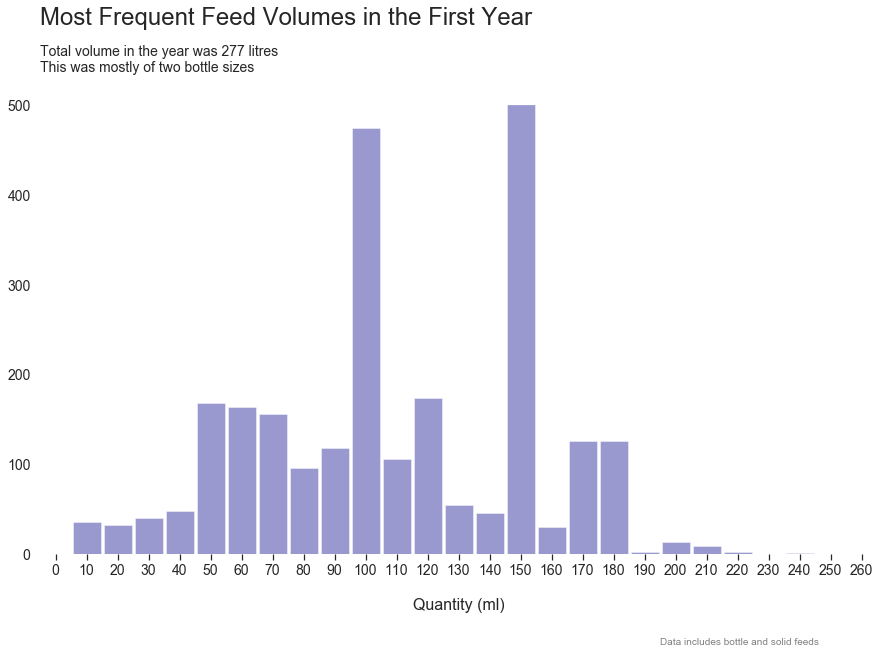

In [23]:
sns.set_style('whitegrid')

# configure plot font family to Arial
#plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'


sns.set(rc={'figure.figsize':(15,8.27),
            'axes.facecolor':'white', 
            'figure.facecolor':'white'})

bins = range(0, max_quantity,10)

ax = sns.distplot(df[' Quantity (ml or g)'] , 
                   kde=False, 
                   bins = bins, 
                   color = 'darkblue',
                   hist_kws={"rwidth": 0.9})


#ax.set(xticks=np.arange(0,max_quantity,25))

# Grids and lines
ax.xaxis.grid() # remove vertical grid
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# X axis
bins_labels(bins)
ax.tick_params(bottom='on')
ax.set_xlabel('Quantity (ml)',fontsize=16)
ax.xaxis.labelpad = 20

for item in ax.get_xticklabels():
    item.set_fontsize(14)

    
# Y Axis
ax.set(ylim=(0, 500))
for item in ax.get_yticklabels():
    item.set_fontsize(14)

# Titles
ax.set_title('Most Frequent Feed Volumes in the First Year'
             , pad=80
             , fontsize=24
             , loc='left')
ax.annotate("Total volume in the year was " 
            + '{:,}'.format(round(sum(df[' Quantity (ml or g)'])/1000 ))+ ' litres\n'
            + "This was mostly of two bottle sizes", 
            xy=(0,1), 
            xycoords="axes fraction",
            xytext=(0,60), 
            textcoords="offset points",
            ha="left", va="top",
            fontsize=14)


ax.text(200, -100,
         'Data includes bottle and solid feeds',
         fontsize=10,
         color='gray')


plt.show()

# Pattern of Feed Types Across the year

In [24]:
df.head(3)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type,row_num,is_liquid
0,2554,2018-03-04 18:25:57,18:40:57 03-04-2018,Bottle,5.07,150,NaN,15,Liquid,METRIC,Formula,1,True
1,2553,2018-03-04 13:58:16,14:07:16 03-04-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,2,True
2,2551,2018-03-04 07:00:58,07:13:06 03-04-2018,Bottle,4.06,120,NaN,12,Liquid,METRIC,Formula,3,True


Derive new columns to visualize feeds using
* month and week of the year 
* time stamp of when feed occured
* whether feed was during the night or day

In [25]:
df['start_time_yymmww_cln'] = df[' Start Time'].map(lambda x: str(x.year) + '-' + str(x.month).zfill(2) + '-' + str(x.week).zfill(2) )
df['start_time_yymmdd_cln'] = df[' Start Time'].map(lambda x: str(x.year) + '-' + str(x.month).zfill(2) + '-' + str(x.day).zfill(2) )

df['start_time_cln'] = df[' Start Time'].dt.time
df['start_time_hr_cln'] = df[' Start Time'].dt.hour
df.head(5)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type,row_num,is_liquid,start_time_yymmww_cln,start_time_yymmdd_cln,start_time_cln,start_time_hr_cln
0,2554,2018-03-04 18:25:57,18:40:57 03-04-2018,Bottle,5.07,150,NaN,15,Liquid,METRIC,Formula,1,True,2018-03-09,2018-03-04,18:25:57,18
1,2553,2018-03-04 13:58:16,14:07:16 03-04-2018,Bottle,4.06,120,NaN,9,Liquid,METRIC,Formula,2,True,2018-03-09,2018-03-04,13:58:16,13
2,2551,2018-03-04 07:00:58,07:13:06 03-04-2018,Bottle,4.06,120,NaN,12,Liquid,METRIC,Formula,3,True,2018-03-09,2018-03-04,07:00:58,7
3,2550,2018-03-04 02:44:10,02:52:49 03-04-2018,Bottle,4.06,120,NaN,8,Liquid,METRIC,Formula,4,True,2018-03-09,2018-03-04,02:44:10,2
4,2549,2018-03-03 18:35:31,18:45:31 03-03-2018,Bottle,5.07,150,NaN,10,Liquid,METRIC,Formula,5,True,2018-03-09,2018-03-03,18:35:31,18


In [26]:
conditions = [
    (df['start_time_hr_cln'] <= 6) | (df['start_time_hr_cln'] >= 23)]
choices = ['night']
df['time_of_day'] = np.select(conditions, choices, default='day')

In [27]:
df_tmp=df
df_tmp.sort_values('start_time_yymmww_cln', ascending=True, inplace=True)
df_tmp.head(5)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type,row_num,is_liquid,start_time_yymmww_cln,start_time_yymmdd_cln,start_time_cln,start_time_hr_cln,time_of_day
2529,2,2017-04-26 09:00:46,09:09:48 04-26-2017,Bottle,2.03,60,NaN,9,Liquid,METRIC,Formula,2530,True,2017-04-17,2017-04-26,09:00:46,9,day
2504,28,2017-04-29 06:52:49,06:59:27 04-29-2017,Bottle,2.37,70,NaN,6,Liquid,METRIC,Formula,2505,True,2017-04-17,2017-04-29,06:52:49,6,night
2503,29,2017-04-29 09:57:21,10:07:30 04-29-2017,Bottle,2.03,60,NaN,10,Liquid,METRIC,Formula,2504,True,2017-04-17,2017-04-29,09:57:21,9,day
2502,30,2017-04-29 12:44:06,12:48:33 04-29-2017,Bottle,2.03,60,NaN,4,Liquid,METRIC,Formula,2503,True,2017-04-17,2017-04-29,12:44:06,12,day
2501,31,2017-04-29 14:55:47,15:30:47 04-29-2017,Bottle,2.03,60,NaN,35,Liquid,METRIC,Formula,2502,True,2017-04-17,2017-04-29,14:55:47,14,day


## Visualize feed times

### Timing of feeds

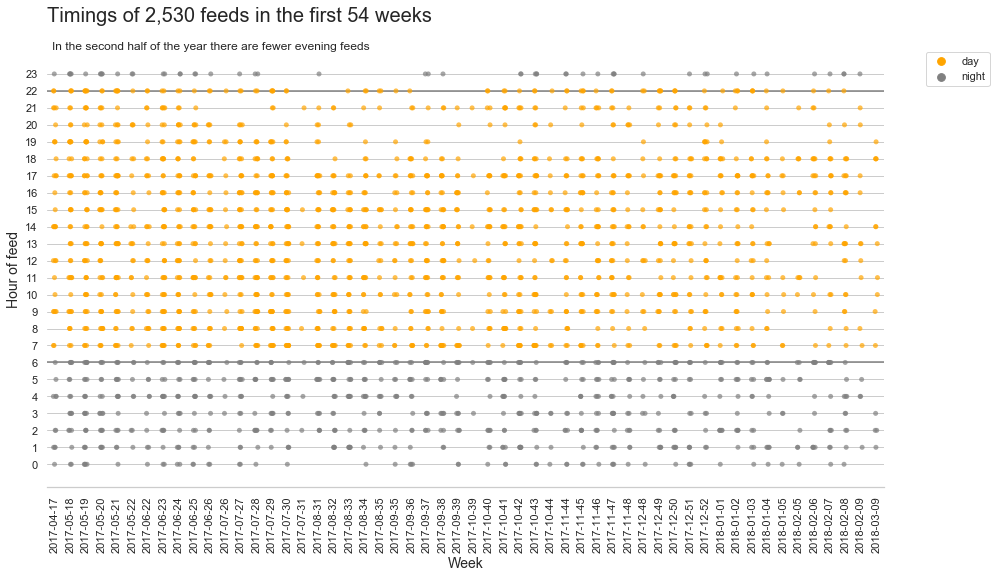

In [28]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
 
# Fonts
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

hue_palette ={"night":"gray","day":"orange"}


ax = sns.stripplot(
    x="start_time_yymmww_cln", 
    y="start_time_hr_cln", 
    hue='time_of_day',
    jitter=True,
    alpha = 0.7,
    palette=hue_palette,
    data=df_tmp)

# Grids and lines
sns.set_style('whitegrid')
ax.spines['right'].set_visible(False)
sns.despine(left=True,right=True)

# X axis labels
ax.set_xlabel('Week',fontsize=14)
for item in ax.get_xticklabels():
    item.set_rotation(90)

# Y axis labels
ax.set_ylabel('Hour of feed',fontsize=14)
ax.set(yticks=np.arange(start=0,stop=24,step=1))


# Titles
ax.set_title('Timings of '+ '{:,}'.format(len(df_tmp)) +' feeds in the first '
             + str(df_tmp['start_time_yymmww_cln'].nunique())+ ' weeks', 
             pad=30, fontsize=20,loc='left')

ax.annotate("In the second half of the year there are fewer evening feeds", 
            xy=(0,1), 
            xycoords="axes fraction",
            xytext=(5,10), 
            textcoords="offset points",
            ha="left", va="top",
            fontsize=12)

# Some lines to highlight things
plt.axhline(y=22, color='gray', linestyle='-')
plt.axhline(y=6, color='gray', linestyle='-')

# Legends and annotations
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Number of feeds

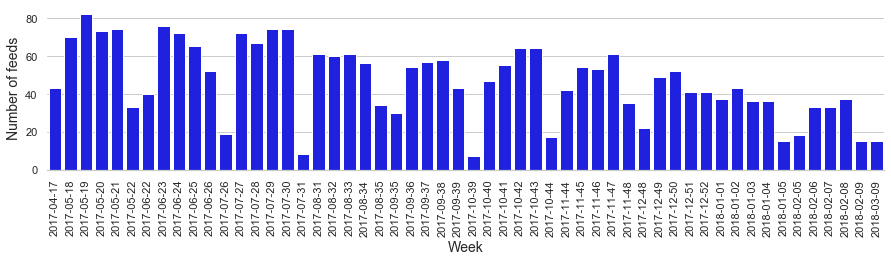

In [29]:
sns.set(rc={'figure.figsize':(15,3)})
sns.set_style('whitegrid')
 
ax2 = sns.countplot(x="start_time_yymmww_cln",color='blue', data=df_tmp)

# Grids and lines
sns.set_style('whitegrid')
ax2.spines['right'].set_visible(False)
sns.despine(left=True,right=True)

# X axis labels
ax2.set_xlabel('Week',fontsize=14)
for item in ax2.get_xticklabels():
    item.set_rotation(90)

# Y axis labels
ax2.set_ylabel('Number of feeds',fontsize=14)
#ax.set(yticks=np.arange(start=0,stop=24,step=1))

plt.show()